# Create Quadtree Grid for McDonald Valley Problem

## Load Modules and Setup Notebook

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

from flopy.utils.gridgen import Gridgen 

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Users/langevin/langevin/dev/flopy3fork.git/flopy
3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.2
matplotlib version: 3.0.3
flopy version: 3.2.12


## Create Base Grid

In [2]:
nlay = 5
nrow = 40
ncol = 25
delr = 500.
delc = 500.
top = 100.
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
botm[0] = -5.
botm[1] = -50
botm[2] = -51
botm[3] = -100
fname = './data/bottom.csv'
botm[4] = np.loadtxt(fname, delimiter=',')
ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(ms, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=top, botm=botm)

## Create Features for Grid Refinement

In [3]:
def get_circle(x, y, r):
    phi = np.arange(0, 2 * np.pi, 0.01)
    return x + r * np.cos(phi), y + r * np.sin(phi)

In [4]:
# wells
well_list = [('Reilly', 6, 15, -67000), 
             ('Virginia City(1)', 35, 16, -268000), 
             ('Virginia City(2)', 33, 6, -268000)]

well_pts = []
for name, row, col, Q in well_list:
    x = col * delr - 0.5 * delr
    y = nrow * delc - row * delc + 0.5 * delc
    print(name, x, y, Q)
    well_pts.append((x, y))
    
r = 1000
well_circles = []
for x, y in well_pts:
    xlist, ylist = get_circle(x, y, r)
    circle = []
    for i in range(xlist.shape[0]):
        circle.append((xlist[i], ylist[i]))
    well_circles.append(circle)

Reilly 7250.0 17250.0 -67000
Virginia City(1) 7750.0 2750.0 -268000
Virginia City(2) 2750.0 3750.0 -268000


In [5]:
# river
river = [(8.5 * delr, 0), (8.5 * delr, 18 * delc)]
for x, y in river:
    print(x, y)

4250.0 0
4250.0 9000.0


In [6]:
# lake
fname = './data/lake_poly.dat'
lake_pts = np.loadtxt(fname)
lake_poly = []
for x, y in lake_pts:
    lake_poly.append((x, y))

## Build the Grid

In [7]:
gridgen_ws = os.path.join('.', '_gridgen')
g = Gridgen(dis, model_ws=gridgen_ws)

rflist = []

#g.add_refinement_features(well_pts, 'point', 3, range(nlay))
#rflist.append(os.path.join(gridgen_ws, 'rf0'))
g.add_refinement_features([well_circles], 'polygon', 3, range(nlay))
rflist.append(os.path.join(gridgen_ws, 'rf0'))

g.add_refinement_features([[lake_poly]], 'polygon', 3, range(nlay))
rflist.append(os.path.join(gridgen_ws, 'rf1'))

g.add_refinement_features([[river]], 'line', 3, range(nlay))
rflist.append(os.path.join(gridgen_ws, 'rf2'))

g.build(verbose=False)

b'GRIDGEN Version 1.0.02 January 6, 2017\nA program for generating unstructured grids.\n\nThis program is public domain and is released on the condition that neither the U.S. Geological Survey nor the United States Government may be held liable for any damages resulting from their authorized or unauthorized use.\n\n- A ModflowGrid2D object was instantiated.\n- A ModflowGrid object was instantiated.\n- A QuadTree object was instantiated.\n  * Refine grid at layer 1\n  * Refine grid at layer 2\n  * Refine grid at layer 3\n  * Refine grid at layer 4\n  * Refine grid at layer 5\n  * Smooth grid: horizontal=1 vertical=1\n  * Build surface elevation\n- Save Quadtree to file: quadtreegrid.tsf\n- Save data to file: quadtreegrid.top1.dat\n- Save data to file: quadtreegrid.top2.dat\n- Save data to file: quadtreegrid.top3.dat\n- Save data to file: quadtreegrid.top4.dat\n- Save data to file: quadtreegrid.top5.dat\n- Save data to file: quadtreegrid.bot1.dat\n- Save data to file: quadtreegrid.bot2.d

## Plot the Gridgen Input

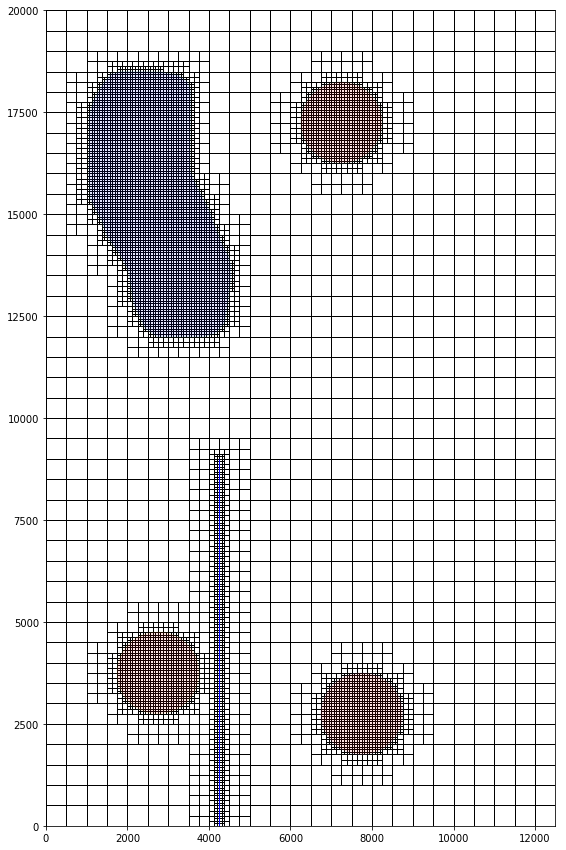

In [8]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms)
g.plot()
flopy.plot.plot_shapefile(rflist[0], ax=ax, facecolor='red', alpha=0.1)
flopy.plot.plot_shapefile(rflist[1], ax=ax, facecolor='blue', alpha=0.1)
flopy.plot.plot_shapefile(rflist[2], ax=ax, edgecolor='blue', linewidth=1)

## Retrieve DISV Information

In [9]:
gridprops_disv = g.get_gridprops_disv()
#gridprops_disv

## Intersect the Grid with the Property Arrays

   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None


Text(0.5, 1.0, 'kclay_qt: 0.003 200.0')

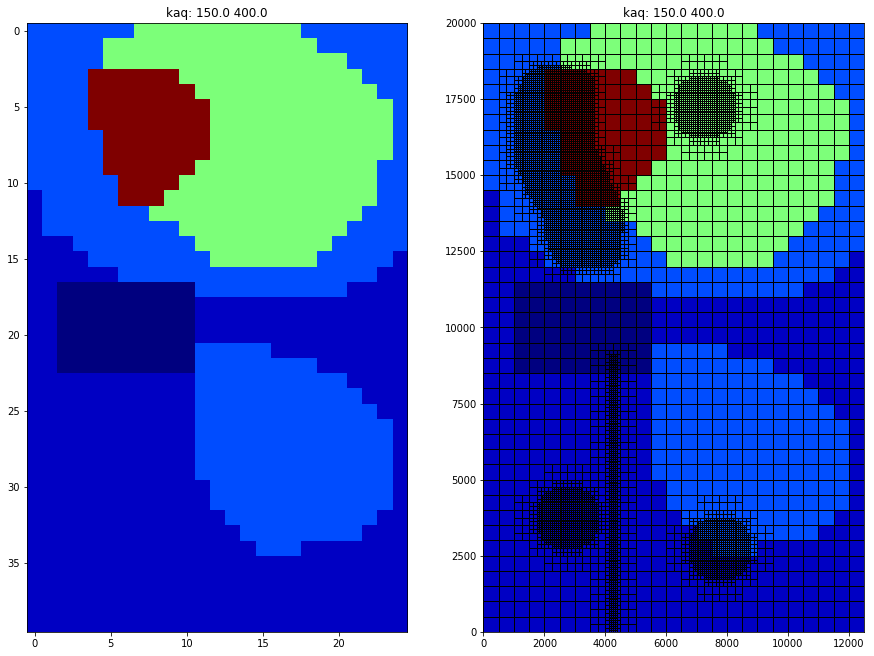

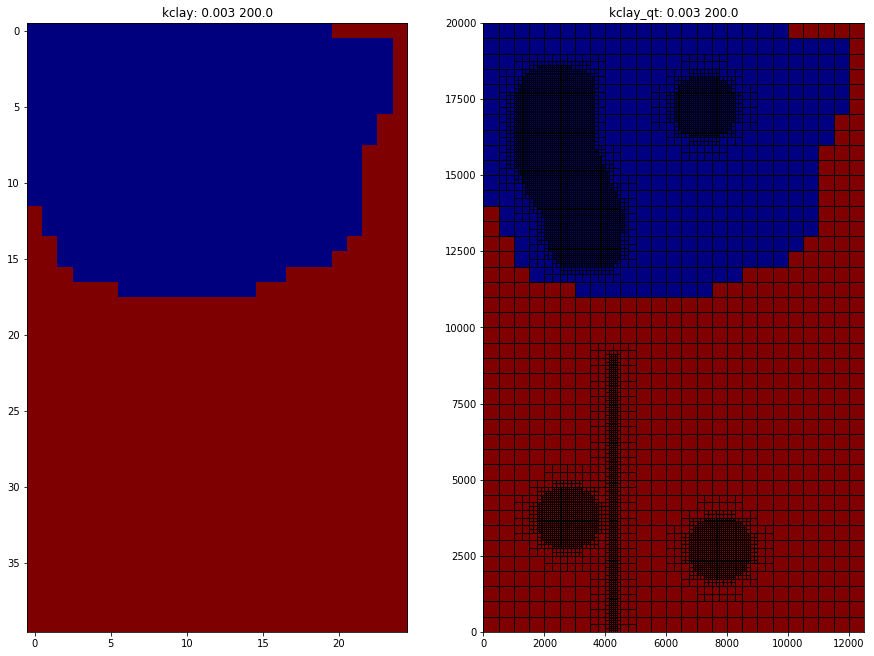

In [10]:
ncpl = gridprops_disv['ncpl']
cellxy = np.empty((ncpl, 2), dtype=np.float)
for n in range(ncpl):
    x, y = g.get_center(n)
    cellxy[n, 0] = x
    cellxy[n, 1] = y

kaq = np.loadtxt('./data/k_aq.csv', delimiter=',')
kaq_qt = ms.sr.interpolate(kaq, cellxy)

from flopy.utils.gridgen import read1d
kclay = np.empty((dis.nrow * dis.ncol), dtype=np.float)
f = open('./data/k_clay.txt', 'r')
kclay = read1d(f, kclay).reshape((dis.nrow, dis.ncol))
kclay_qt = ms.sr.interpolate(kclay, cellxy)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.imshow(kaq, vmin=kaq.min(), vmax=kaq.max(), cmap='jet')
ax.set_title('kaq: {} {}'.format(kaq.min(), kaq.max()))
ax = fig.add_subplot(1, 2, 2, aspect='equal')
g.plot(ax=ax, a=kaq_qt, vmin=kaq.min(), vmax=kaq.max(), cmap='jet')
ax.set_title('kaq: {} {}'.format(kaq_qt.min(), kaq_qt.max()))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.imshow(kclay, vmin=kclay.min(), vmax=kclay.max(), cmap='jet')
ax.set_title('kclay: {} {}'.format(kclay.min(), kclay.max()))
ax = fig.add_subplot(1, 2, 2, aspect='equal')
g.plot(ax=ax, a=kclay_qt, vmin=kclay_qt.min(), vmax=kclay_qt.max(), cmap='jet')
ax.set_title('kclay_qt: {} {}'.format(kclay_qt.min(), kclay_qt.max()))

## Intersect the Features with the Grid

In [11]:
well_intersect = g.intersect(well_pts, 'point', 0)
print(well_intersect)
print(well_intersect.dtype)

[(1678, 0, 0) (8566, 1, 1) (7381, 2, 2)]
(numpy.record, [('nodenumber', '<i8'), ('pointid', '<i8'), ('SHAPEID', '<i8')])


In [12]:
lake_intersect = g.intersect([[lake_poly]], 'polygon', 0)
print(lake_intersect)
print(lake_intersect.dtype)
print('number of lake cells: {}'.format(lake_intersect.shape))

[( 203, 0, 3906.25 , 0) ( 207, 0, 3906.25 , 0) ( 206, 0, 3906.25 , 0) ...
 (5939, 0,  289.445, 0) (5941, 0, 1391.14 , 0) (5945, 0,  770.668, 0)]
(numpy.record, [('nodenumber', '<i8'), ('polyid', '<i8'), ('totalarea', '<f8'), ('SHAPEID', '<i8')])
number of lake cells: (4212,)


In [13]:
river_intersect = g.intersect([[river]], 'line', 0)
#print(river_intersect)
print(river_intersect.dtype)
print('number of river cells: {}'.format(river_intersect.shape))

#f = open('mv.riv.dimensions.dat', 'w')
#f.write('  MAXBOUND {}\n'.format(river_intersect.shape[0]))
#f.close()

#f = open('mv.riv.period1.dat', 'w')
rivspd = []
rbot = -2.
for i, icell in enumerate(river_intersect.nodenumber):
    cond = 1.e5
    length = river_intersect['length'][i]
    distance = (river_intersect['starting_distance'][i] +
                river_intersect['ending_distance'][i]) / 2.
    stage = 0 + distance / (18 * delc)
    cond = cond / delc * length
    rivspd.append([(0, icell), stage, cond, rbot])

(numpy.record, [('nodenumber', '<i8'), ('arcid', '<i8'), ('length', '<f8'), ('starting_distance', '<f8'), ('ending_distance', '<f8'), ('SHAPEID', '<i8')])
number of river cells: (288,)


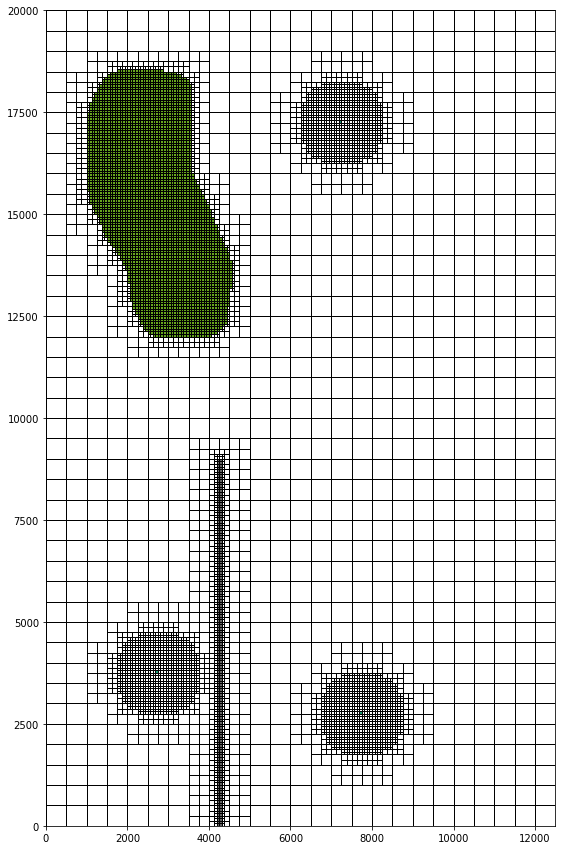

In [14]:
ibd = np.zeros((g.nodelay[0]), dtype=np.int)
ibd[well_intersect.nodenumber] = 1
ibd[lake_intersect.nodenumber] = 2
ibd[river_intersect.nodenumber] = 3

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
pc = g.plot(ax=ax, a=ibd, masked_values=[0])

## Build the Model

In [15]:
ws = './model'
name = 'mv'
sim = flopy.mf6.MFSimulation(sim_ws=ws, sim_name=name, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, complexity='complex')
gwf = flopy.mf6.ModflowGwf(sim, save_flows=True)
dis = flopy.mf6.ModflowGwfdisv(gwf, **gridprops_disv)
ic = flopy.mf6.ModflowGwfic(gwf, strt=11.)
npf = flopy.mf6.ModflowGwfnpf(gwf, 
                              xt3doptions=True, save_specific_discharge=True,
                              icelltype=[1, 0, 0, 0, 0],
                              k=[kaq_qt, kaq_qt, kclay_qt, kaq_qt, kaq_qt],
                              k33=[0.25 * kaq_qt, 0.25 * kaq_qt, kclay_qt, 0.25 * kaq_qt, 0.25 * kaq_qt])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[((0, rec[0]), 11.) for rec in lake_intersect])
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=.003641)
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)
oc = flopy.mf6.ModflowGwfoc(gwf, 
                            head_filerecord=name + '.hds', 
                            budget_filerecord=name + '.bud',
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 4212 based on size of stress_period_data
    writing package rcha...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 288 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/langevin/langevin/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

  MODFLOW 6 compiled Mar 14 2019 09:20:00 with GFORTRAN compiler (ver. 8.2.0)

This software has been approved for release by the U.S. Geological 
Survey 

(True, [])

## Post-Process the Results

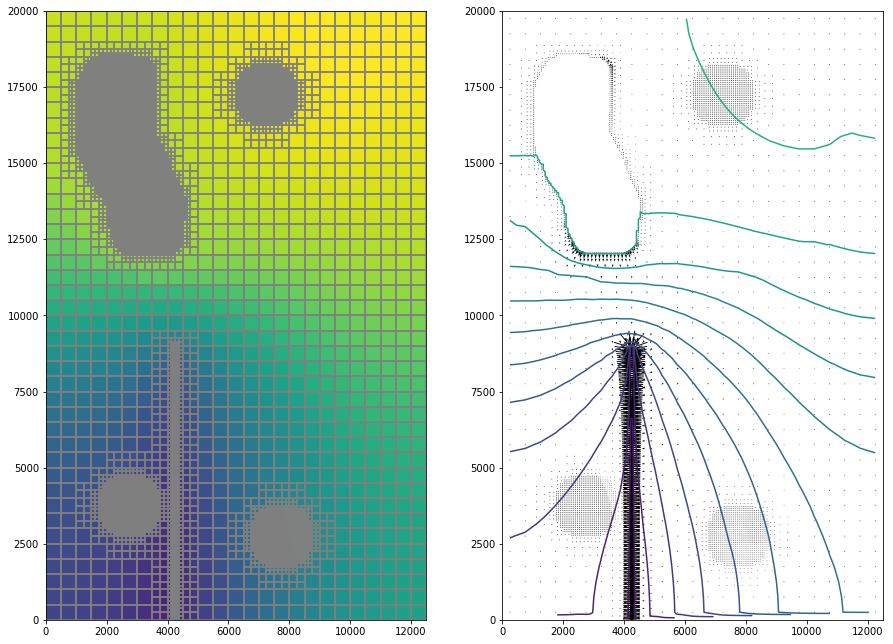

In [16]:
from flopy.utils.binaryfile import HeadFile, CellBudgetFile
fname = os.path.join(ws, name + '.hds')
headobj = HeadFile(fname)
head = headobj.get_data()[:, 0, :]
fname = os.path.join(ws, name + '.bud')
budobj = CellBudgetFile(fname, precision='double')
spdis = budobj.get_data(text='DATA-SPDIS')

ilay = 0

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
pmv.plot_array(head)
pmv.plot_grid()

ax = fig.add_subplot(1, 2, 2, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
pmv.contour_array(head, levels=np.arange(20))
pmv.plot_specific_discharge(spdis)